In [55]:
import numpy as np
import pandas as pd
from datetime import datetime
import xarray as xr
from scipy.spatial import cKDTree

In [93]:
eccc_precip = pd.read_csv('../data/eccc_data/eccc_6h_precip_data.csv').drop(columns=['Unnamed: 0', 'datetime'])
eccc_data = pd.read_csv('../data/eccc_data/all_eccc_data.csv').drop(columns=['PRECIP_AMOUNT'])
bch_obs = pd.read_csv('../data/julie_bch_obs/processed_bch_obs.csv', converters={
                "UTC_DATE": lambda x: x + '+00:00'}).drop(columns=['Unnamed: 0'])

# Merge ECCC data with 6h accumulated precip

In [48]:
eccc_precip = eccc_precip[eccc_precip['6h_precip'] < 100]
print(eccc_precip['6h_precip'].isna().sum())
eccc_precip

0


,x,y,ID,STN_ID,UTC_DATE,PRECIP_AMOUNT,PRECIP_AMOUNT_FLAG,6h_precip
1,-123.439333,48.431972,1012710.2022.12.31.22,52,2023-01-01 06:00:00+00:00,0.0,NaN,0.0
2,-123.439333,48.431972,1012710.2023.1.1.4,52,2023-01-01 12:00:00+00:00,0.0,NaN,0.0
3,-123.439333,48.431972,1012710.2023.1.1.10,52,2023-01-01 18:00:00+00:00,0.0,NaN,0.0
4,-123.439333,48.431972,1012710.2023.1.1.16,52,2023-01-02 00:00:00+00:00,0.0,NaN,0.0
5,-123.439333,48.431972,1012710.2023.1.1.22,52,2023-01-02 06:00:00+00:00,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...
278498,-124.292502,54.459455,1092977.2024.1.2.16,55363,2024-01-03 00:00:00+00:00,0.0,NaN,0.0
278499,-124.292502,54.459455,1092977.2024.1.2.22,55363,2024-01-03 06:00:00+00:00,0.0,NaN,0.0
278500,-124.292502,54.459455,1092977.2024.1.3.4,55363,2024-01-03 12:00:00+00:00,0.0,NaN,0.0
278501,-124.292502,54.459455,1092977.2024.1.3.10,55363,2024-01-03 18:00:00+00:00,0.0,NaN,0.0


In [ ]:
eccc_data

,x,y,ID,STN_ID,UTC_DATE,TEMP,WIND_SPEED,WIND_DIRECTION
0,-113.638636,50.003631,3031640.2022.11.19.5,2224,2022-11-19 12:00:00+00:00,-15.7,6.0,11.0
1,-124.900000,49.716667,1021830.2022.11.19.4,155,2022-11-19 12:00:00+00:00,-1.2,8.0,29.0
2,-124.160278,49.350278,1020590.2022.11.19.4,138,2022-11-19 12:00:00+00:00,2.9,13.0,23.0
3,-123.044745,48.783907,1017101.2022.11.19.4,96,2022-11-19 12:00:00+00:00,3.6,12.0,8.0
4,-123.529917,48.574917,1014820.2022.11.19.4,65,2022-11-19 12:00:00+00:00,1.2,NaN,NaN
...,...,...,...,...,...,...,...,...
422910,-123.002246,49.125848,1102415.2023.9.12.22,49088,2023-09-13 06:00:00+00:00,14.2,0.0,0.0
422911,-128.156667,52.185000,1060815.2023.9.12.22,49388,2023-09-13 06:00:00+00:00,13.1,15.0,18.0
422912,-120.778056,50.112502,1125073.2023.9.12.22,49408,2023-09-13 06:00:00+00:00,13.7,4.0,28.0
422913,-112.862502,50.303613,3036500.2023.9.12.23,46914,2023-09-13 06:00:00+00:00,17.5,18.0,25.0


In [73]:
eccc_dt = eccc_data.UTC_DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00'))
year_mask = eccc_dt.apply(lambda x: x.year == 2022)
print(len(eccc_dt[year_mask]))

140784


In [50]:
print(eccc_data.ID.nunique())

422915


In [75]:
eccc = eccc_data.merge(eccc_precip[['ID', 'PRECIP_AMOUNT']], on='ID', how='outer')
eccc_dt = eccc.UTC_DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00'))
year_mask = eccc_dt.apply(lambda x: x.year != 2022)
eccc = eccc[year_mask]
eccc

,x,y,ID,STN_ID,UTC_DATE,TEMP,WIND_SPEED,WIND_DIRECTION,PRECIP_AMOUNT
340,-123.225700,48.424608,1012475.2022.12.31.16,27226,2023-01-01 00:00:00+00:00,8.3,7.0,27.0,NaN
341,-123.225700,48.424608,1012475.2022.12.31.22,27226,2023-01-01 06:00:00+00:00,6.5,9.0,26.0,NaN
737,-123.225700,48.424608,1012475.2023.1.1.10,27226,2023-01-01 18:00:00+00:00,5.9,3.0,5.0,NaN
738,-123.225700,48.424608,1012475.2023.1.1.16,27226,2023-01-02 00:00:00+00:00,6.9,10.0,10.0,NaN
739,-123.225700,48.424608,1012475.2023.1.1.22,27226,2023-01-02 06:00:00+00:00,6.1,23.0,7.0,NaN
...,...,...,...,...,...,...,...,...,...
422910,-117.199167,55.098056,3076680.2024.1.3.17,32460,2024-01-04 00:00:00+00:00,-8.0,5.0,17.0,0.0
422911,-117.199167,55.098056,3076680.2024.1.3.23,32460,2024-01-04 06:00:00+00:00,-8.4,0.0,0.0,NaN
422912,-117.199167,55.098056,3076680.2024.1.3.5,32460,2024-01-03 12:00:00+00:00,-9.7,7.0,18.0,0.0
422913,-117.199167,55.098056,3076680.2024.1.4.11,32460,2024-01-04 18:00:00+00:00,-11.6,8.0,1.0,NaN


76425


<Axes: >

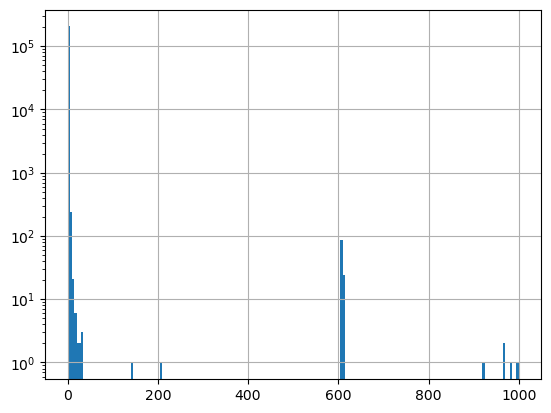

In [76]:
print(eccc['PRECIP_AMOUNT'].isna().sum())
eccc['PRECIP_AMOUNT'].hist(bins=200, log=True)

<Axes: >

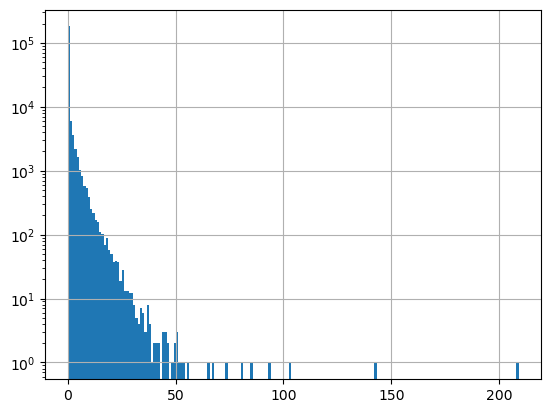

In [77]:
eccc_precip[eccc_precip['6h_precip'] < 500]['6h_precip'].hist(bins=200, log=True)

In [78]:
eccc_precip[eccc_precip['6h_precip'] < 500]

,x,y,ID,STN_ID,UTC_DATE,PRECIP_AMOUNT,PRECIP_AMOUNT_FLAG,6h_precip
1,-123.439333,48.431972,1012710.2022.12.31.22,52,2023-01-01 06:00:00+00:00,0.0,NaN,0.0
2,-123.439333,48.431972,1012710.2023.1.1.4,52,2023-01-01 12:00:00+00:00,0.0,NaN,0.0
3,-123.439333,48.431972,1012710.2023.1.1.10,52,2023-01-01 18:00:00+00:00,0.0,NaN,0.0
4,-123.439333,48.431972,1012710.2023.1.1.16,52,2023-01-02 00:00:00+00:00,0.0,NaN,0.0
5,-123.439333,48.431972,1012710.2023.1.1.22,52,2023-01-02 06:00:00+00:00,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...
278498,-124.292502,54.459455,1092977.2024.1.2.16,55363,2024-01-03 00:00:00+00:00,0.0,NaN,0.0
278499,-124.292502,54.459455,1092977.2024.1.2.22,55363,2024-01-03 06:00:00+00:00,0.0,NaN,0.0
278500,-124.292502,54.459455,1092977.2024.1.3.4,55363,2024-01-03 12:00:00+00:00,0.0,NaN,0.0
278501,-124.292502,54.459455,1092977.2024.1.3.10,55363,2024-01-03 18:00:00+00:00,0.0,NaN,0.0


In [94]:
bch_obs

,UTC_DATE,x,y,STN_ID,TEMP,PRECIP_AMOUNT
0,2023-01-01 00:00:00+00:00,-123.138056,55.305278,YZY,-4.9,NaN
1,2023-01-01 06:00:00+00:00,-123.138056,55.305278,YZY,-5.1,0.0
2,2023-01-01 12:00:00+00:00,-123.138056,55.305278,YZY,-2.9,0.0
3,2023-01-01 18:00:00+00:00,-123.138056,55.305278,YZY,-2.0,0.0
4,2023-01-02 00:00:00+00:00,-123.138056,55.305278,YZY,-1.5,0.0
...,...,...,...,...,...,...
305135,2023-12-30 18:00:00+00:00,-122.486256,49.287453,ALU,8.0,1.0
305136,2023-12-31 00:00:00+00:00,-122.486256,49.287453,ALU,8.4,1.4
305137,2023-12-31 06:00:00+00:00,-122.486256,49.287453,ALU,7.2,6.8
305138,2023-12-31 12:00:00+00:00,-122.486256,49.287453,ALU,6.8,1.0


<Axes: >

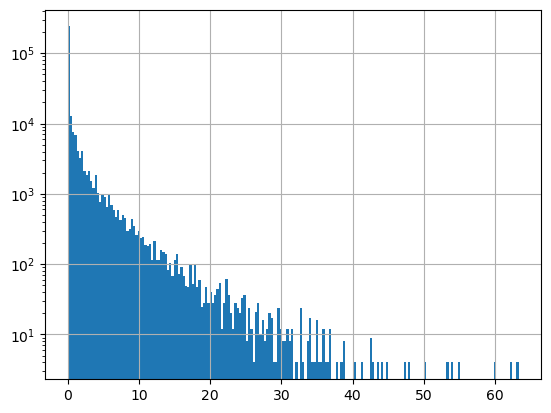

In [95]:
bch_obs['PRECIP_AMOUNT'].hist(bins=200, log=True)

In [96]:
def print_stats(x):
    print(' - min : ', x.min())
    print(' - max : ', x.max())
    print(' - mean : ', x.mean())
    print(' - std : ', x.std())

In [97]:
print_stats(eccc_precip[eccc_precip['6h_precip'] < 500]['6h_precip'])
print_stats(bch_obs['PRECIP_AMOUNT'])

 - min :  0.0
 - max :  209.0
 - mean :  0.47277921083390434
 - std :  2.08394740593479
 - min :  0.0
 - max :  63.3
 - mean :  0.7307460963506904
 - std :  2.5212868311965364


# Clip BC Hydro stations to evaluation domain

In [98]:
climatex_ds = xr.open_dataset(
        "../data/prediction_data/bris-lam-inference-20230101T12-20230102T12.nc"
    )
wrf_ds = xr.open_dataset("../data/wrf_data/wrfout_d02_processed_23012000.nc")

In [99]:
src_coords = np.column_stack(
    (wrf_ds.XLONG.values.flatten(), wrf_ds.XLAT.values.flatten())
)  # source coords is WAC00WG-01 XLONG/XLAT
tgt_coords = np.column_stack(
    (climatex_ds.longitude.values, climatex_ds.latitude.values)
)

In [100]:
def clip_stations(station_coords, src_coords, tgt_coords, tolerance=0.03):
    tree_src = cKDTree(src_coords)
    tree_tgt = cKDTree(tgt_coords)

    src_near = np.array(
        [
            len(idx) > 0
            for idx in tree_src.query_ball_point(station_coords, r=tolerance)
        ]
    )
    tgt_near = np.array(
        [
            len(idx) > 0
            for idx in tree_tgt.query_ball_point(station_coords, r=tolerance)
        ]
    )

    return src_near & tgt_near

In [101]:
station_coords = bch_obs[['x','y']].to_numpy()
mask = clip_stations(
    station_coords=station_coords,
    src_coords=src_coords,
    tgt_coords=tgt_coords,
)
clipped_bch_obs = bch_obs[mask].copy()

In [102]:
clipped_bch_obs

,UTC_DATE,x,y,STN_ID,TEMP,PRECIP_AMOUNT
0,2023-01-01 00:00:00+00:00,-123.138056,55.305278,YZY,-4.9,NaN
1,2023-01-01 06:00:00+00:00,-123.138056,55.305278,YZY,-5.1,0.0
2,2023-01-01 12:00:00+00:00,-123.138056,55.305278,YZY,-2.9,0.0
3,2023-01-01 18:00:00+00:00,-123.138056,55.305278,YZY,-2.0,0.0
4,2023-01-02 00:00:00+00:00,-123.138056,55.305278,YZY,-1.5,0.0
...,...,...,...,...,...,...
305135,2023-12-30 18:00:00+00:00,-122.486256,49.287453,ALU,8.0,1.0
305136,2023-12-31 00:00:00+00:00,-122.486256,49.287453,ALU,8.4,1.4
305137,2023-12-31 06:00:00+00:00,-122.486256,49.287453,ALU,7.2,6.8
305138,2023-12-31 12:00:00+00:00,-122.486256,49.287453,ALU,6.8,1.0


In [103]:
obs_data = pd.concat((eccc, clipped_bch_obs), axis=0, ignore_index=True)
obs_data

,x,y,ID,STN_ID,UTC_DATE,TEMP,WIND_SPEED,WIND_DIRECTION,PRECIP_AMOUNT
0,-123.225700,48.424608,1012475.2022.12.31.16,27226,2023-01-01 00:00:00+00:00,8.3,7.0,27.0,NaN
1,-123.225700,48.424608,1012475.2022.12.31.22,27226,2023-01-01 06:00:00+00:00,6.5,9.0,26.0,NaN
2,-123.225700,48.424608,1012475.2023.1.1.10,27226,2023-01-01 18:00:00+00:00,5.9,3.0,5.0,NaN
3,-123.225700,48.424608,1012475.2023.1.1.16,27226,2023-01-02 00:00:00+00:00,6.9,10.0,10.0,NaN
4,-123.225700,48.424608,1012475.2023.1.1.22,27226,2023-01-02 06:00:00+00:00,6.1,23.0,7.0,NaN
...,...,...,...,...,...,...,...,...,...
581426,-122.486256,49.287453,NaN,ALU,2023-12-30 18:00:00+00:00,8.0,NaN,NaN,1.0
581427,-122.486256,49.287453,NaN,ALU,2023-12-31 00:00:00+00:00,8.4,NaN,NaN,1.4
581428,-122.486256,49.287453,NaN,ALU,2023-12-31 06:00:00+00:00,7.2,NaN,NaN,6.8
581429,-122.486256,49.287453,NaN,ALU,2023-12-31 12:00:00+00:00,6.8,NaN,NaN,1.0


In [104]:
obs_data.to_csv('../data/processed_eccc_bch_obs.csv')

In [105]:
obs_df = pd.read_csv('../data/processed_eccc_bch_obs.csv', converters={
                "UTC_DATE": lambda x: pd.to_datetime(
                    x, format="%Y-%m-%d %H:%M:%S+00:00"
                ).tz_localize("utc")
            }).drop(columns='Unnamed: 0')
obs_df

/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_54341/2933292845.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_df = pd.read_csv('../data/processed_eccc_bch_obs.csv', converters={


,x,y,ID,STN_ID,UTC_DATE,TEMP,WIND_SPEED,WIND_DIRECTION,PRECIP_AMOUNT
0,-123.225700,48.424608,1012475.2022.12.31.16,27226,2023-01-01 00:00:00+00:00,8.3,7.0,27.0,NaN
1,-123.225700,48.424608,1012475.2022.12.31.22,27226,2023-01-01 06:00:00+00:00,6.5,9.0,26.0,NaN
2,-123.225700,48.424608,1012475.2023.1.1.10,27226,2023-01-01 18:00:00+00:00,5.9,3.0,5.0,NaN
3,-123.225700,48.424608,1012475.2023.1.1.16,27226,2023-01-02 00:00:00+00:00,6.9,10.0,10.0,NaN
4,-123.225700,48.424608,1012475.2023.1.1.22,27226,2023-01-02 06:00:00+00:00,6.1,23.0,7.0,NaN
...,...,...,...,...,...,...,...,...,...
581426,-122.486256,49.287453,NaN,ALU,2023-12-30 18:00:00+00:00,8.0,NaN,NaN,1.0
581427,-122.486256,49.287453,NaN,ALU,2023-12-31 00:00:00+00:00,8.4,NaN,NaN,1.4
581428,-122.486256,49.287453,NaN,ALU,2023-12-31 06:00:00+00:00,7.2,NaN,NaN,6.8
581429,-122.486256,49.287453,NaN,ALU,2023-12-31 12:00:00+00:00,6.8,NaN,NaN,1.0
